In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/lung-CT-npy

/content/drive/MyDrive/Colab Notebooks/lung-CT-npy


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import pickle
from sklearn.metrics import roc_curve, auc





if torch.backends.mps.is_available():
    print("MPS is available.")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

print("device: {}".format(device))

CUDA is available.
device: cuda


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(BaseUNet, self).__init__()
        features = init_features
        # Encoding path
        self.encoder1 = BaseUNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = BaseUNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = BaseUNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = BaseUNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = BaseUNet._block(features * 8, features * 16, name="bottleneck")

        # Decoding path
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = BaseUNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = BaseUNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = BaseUNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = BaseUNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        #return torch.sigmoid(self.conv(dec1))
        return self.conv(dec1)


    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )



In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32, input_size=(256, 256)):
        super(UNet, self).__init__()
        features = init_features
        H, W = input_size  # Extract initial spatial dimensions

        # Precompute spatial dimensions after each pooling layer
        self.spatial_dims = {
            "enc1": (H, W),
            "enc2": (H // 2, W // 2),
            "enc3": (H // 4, W // 4),
            "enc4": (H // 8, W // 8),
            "bottleneck": (H // 16, W // 16),
        }

        # Encoding path
        self.encoder1 = UNet._block(in_channels, features, spatial_dims=self.spatial_dims["enc1"])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, spatial_dims=self.spatial_dims["enc2"])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, spatial_dims=self.spatial_dims["enc3"])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, spatial_dims=self.spatial_dims["enc4"])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = UNet._block(features * 8, features * 16, spatial_dims=self.spatial_dims["bottleneck"])

        # Decoding path
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block(features * 8 * 2, features * 8, spatial_dims=self.spatial_dims["enc4"])
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 4 * 2, features * 4, spatial_dims=self.spatial_dims["enc3"])
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 2 * 2, features * 2, spatial_dims=self.spatial_dims["enc2"])
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, spatial_dims=self.spatial_dims["enc1"])

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, spatial_dims):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.LayerNorm([features, *spatial_dims]),  # Normalize over channels and spatial dimensions
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.LayerNorm([features, *spatial_dims]),  # Normalize again
            nn.ReLU(inplace=True)
        )


In [6]:
main_dir = '/content/drive/MyDrive/Colab Notebooks/lung-CT-npy'

class LungCTDataset(Dataset):
  def __init__(self, data_pickle, mask_pickle):
    super(LungCTDataset, self).__init__()

    with open(data_pickle, 'rb') as f:
      self.data = pickle.load(f)
    with open(mask_pickle, 'rb') as f:
      self.mask = pickle.load(f)

    # preload all data and mask in RAM
    self.data = [np.load(data) for data in self.data]
    self.mask = [np.load(mask) for mask in self.mask]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    # load scan and mask in torch tensor format
    scan = torch.tensor(self.data[idx]).to(device).float()
    mask = torch.tensor(self.mask[idx]).to(device).float()

    # add channel dimension
    scan = scan.unsqueeze(0)
    mask = mask.unsqueeze(0)

    return scan, mask

# load datasets from disk
cancer_train_dataset = torch.load('/content/drive/MyDrive/Colab Notebooks/lung-CT-npy/cancer_train_dataset.pth')
cancer_val_dataset = torch.load('/content/drive/MyDrive/Colab Notebooks/lung-CT-npy/cancer_val_dataset.pth')
cancer_test_dataset = torch.load('/content/drive/MyDrive/Colab Notebooks/lung-CT-npy/cancer_test_dataset.pth')

# print the size of each dataset
print("cancer_train_dataset: {}".format(len(cancer_train_dataset)))
print("cancer_val_dataset: {}".format(len(cancer_val_dataset)))
print("cancer_test_dataset: {}".format(len(cancer_test_dataset)))


<ipython-input-6-198782b8f91a>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cancer_train_dataset = torch.load('/content/drive/MyDrive/Colab Notebooks/lung-CT-npy/cancer

cancer_train_dataset: 1153
cancer_val_dataset: 247
cancer_test_dataset: 248


In [7]:
# choose model
model_1_name = '11_21_batch_1_lr-3_alpha75_cancer_only.pth'
model_2_name = '11_24_batch_1_lr-3_alpha75_cancer_only_layer_norm.pth'
model_3_name = '11_24_batch_1_lr-3_alpha75_cancer_only_layer_norm_Dice.pth'
model_4_name = '11_24_batch_1_lr-3_alpha75_cancer_only_layer_norm_Focal.pth'

model_1 = BaseUNet().to(device)
model_2 = UNet().to(device)
model_3 = UNet().to(device)
model_4 = UNet().to(device)

model_1.load_state_dict(torch.load(os.path.join(main_dir, model_1_name)))
model_2.load_state_dict(torch.load(os.path.join(main_dir, model_2_name)))
model_3.load_state_dict(torch.load(os.path.join(main_dir, model_3_name)))
model_4.load_state_dict(torch.load(os.path.join(main_dir, model_4_name)))


<ipython-input-7-b31e9e9f463f>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(os.path.join(main_dir, model_1_name)))
<ipython-input-7-b

<All keys matched successfully>

In [8]:
# trainloader, valloader, testloader
trainloader = DataLoader(cancer_train_dataset, batch_size=1, shuffle=True)
valloader = DataLoader(cancer_val_dataset, batch_size=1, shuffle=True)
testloader = DataLoader(cancer_test_dataset, batch_size=1, shuffle=True)




In [ ]:
# create ROC curve for each model using trainloader
# take the average of all samples in the trainloader
# y axis: sensitivity
# x axis: 1-specificity

def get_roc_curve(model, dataloader):
  model.eval()
  model.to(device)
  with torch.no_grad():
    y_true = []
    y_score = []
    for i, (scan, mask) in enumerate(dataloader):
      output = model(scan)
      output = torch.sigmoid(output)
      output = output.cpu().numpy().flatten()
      mask = mask.cpu().numpy().flatten()
      y_true.extend(mask)
      y_score.extend(output)
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  return fpr, tpr, thresholds, roc_auc

fpr_1, tpr_1, thresholds_1, roc_auc_1 = get_roc_curve(model_1, trainloader)
fpr_2, tpr_2, thresholds_2, roc_auc_2 = get_roc_curve(model_2, trainloader)
fpr_3, tpr_3, thresholds_3, roc_auc_3 = get_roc_curve(model_3, trainloader)
fpr_4, tpr_4, thresholds_4, roc_auc_4 = get_roc_curve(model_4, trainloader)




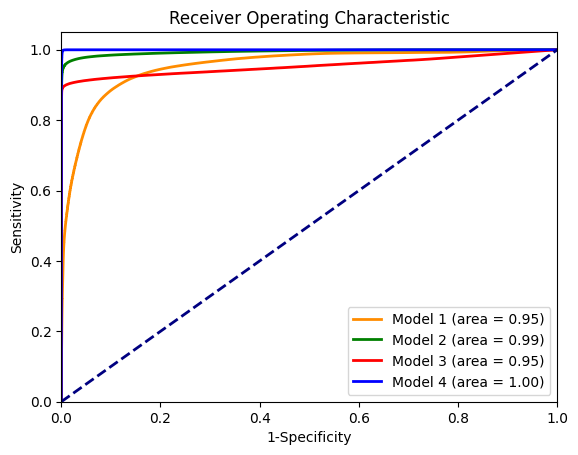

In [ ]:
# plot ROC curve for all models
plt.figure()
lw = 2
plt.plot(fpr_1, tpr_1, color='darkorange',
         lw=lw, label='Model 1 (area = %0.2f)' % roc_auc_1)
plt.plot(fpr_2, tpr_2, color='green',
            lw=lw, label='Model 2 (area = %0.2f)' % roc_auc_2)
plt.plot(fpr_3, tpr_3, color='red',
            lw=lw, label='Model 3 (area = %0.2f)' % roc_auc_3)
plt.plot(fpr_4, tpr_4, color='blue',
            lw=lw, label='Model 4 (area = %0.2f)' % roc_auc_4)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# find the best threshold for each model
def find_best_threshold(fpr, tpr, thresholds):
  best_threshold = thresholds[np.argmax(tpr - fpr)]
  return best_threshold

best_threshold_1 = find_best_threshold(fpr_1, tpr_1, thresholds_1)
best_threshold_2 = find_best_threshold(fpr_2, tpr_2, thresholds_2)
best_threshold_3 = find_best_threshold(fpr_3, tpr_3, thresholds_3)
best_threshold_4 = find_best_threshold(fpr_4, tpr_4, thresholds_4)

In [ ]:
# print all thresholds
print("best threshold for model 1: {}".format(best_threshold_1))
print("best threshold for model 2: {}".format(best_threshold_2))
print("best threshold for model 3: {}".format(best_threshold_3))
print("best threshold for model 4: {}".format(best_threshold_4))

best threshold for model 1: 3.975856088800356e-05
best threshold for model 2: 1.526314008515328e-05
best threshold for model 3: 3.019135874637868e-08
best threshold for model 4: 0.20249894261360168


best threshold for model 1: 3.975856088800356e-05


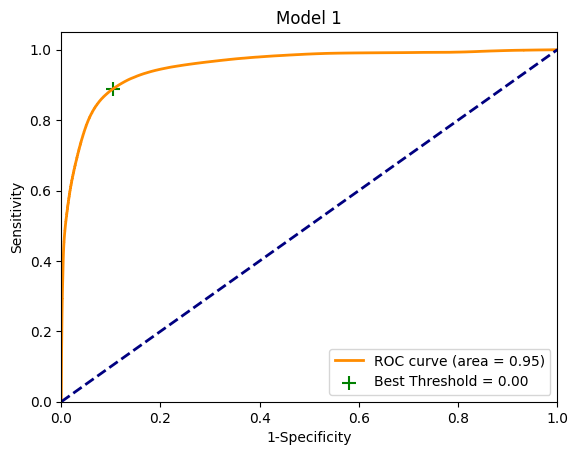

best threshold for model 2: 1.526314008515328e-05


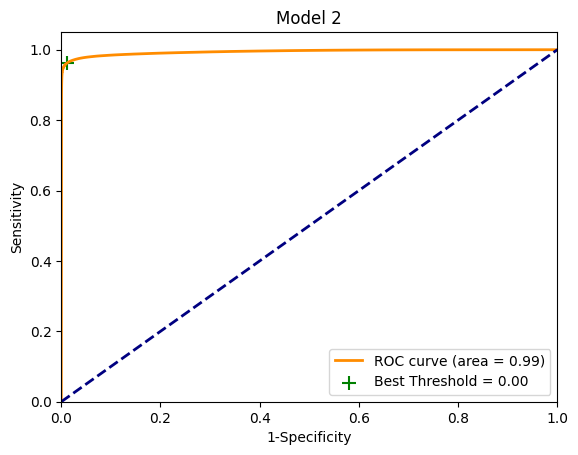

best threshold for model 3: 3.019135874637868e-08


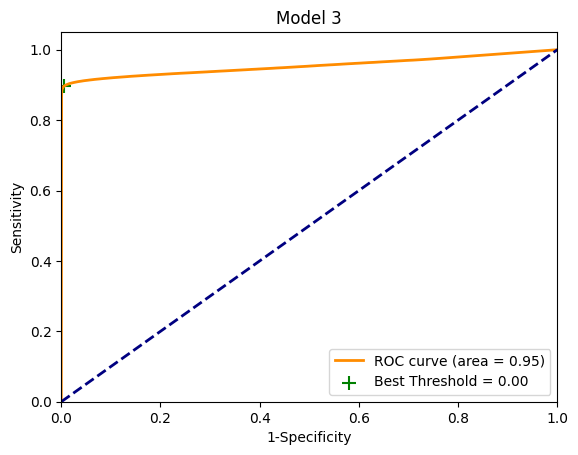

best threshold for model 4: 0.20249894261360168


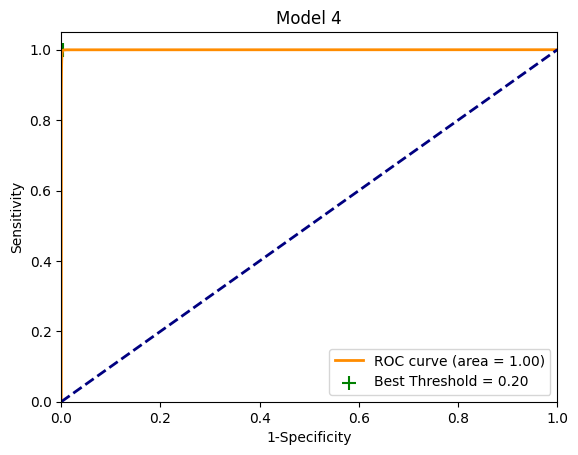

In [ ]:
# plot all ROC curves with best threshold separately
all_fpr = [fpr_1, fpr_2, fpr_3, fpr_4]
all_tpr = [tpr_1, tpr_2, tpr_3, tpr_4]
all_thresholds = [thresholds_1, thresholds_2, thresholds_3, thresholds_4]
all_best_thresholds = [best_threshold_1, best_threshold_2, best_threshold_3, best_threshold_4]
all_roc_auc = [roc_auc_1, roc_auc_2, roc_auc_3, roc_auc_4]


for i in range(len(all_fpr)):
    best_threshold_index = np.argmax(all_tpr[i] - all_fpr[i])
    best_fpr = all_fpr[i][best_threshold_index]
    best_tpr = all_tpr[i][best_threshold_index]
    print("best threshold for model {}: {}".format(i+1, all_thresholds[i][best_threshold_index]))

    best_threshold = all_thresholds[i][best_threshold_index]

    plt.figure()
    lw = 2
    plt.plot(all_fpr[i], all_tpr[i], color='darkorange',
                lw=lw, label='ROC curve (area = %0.2f)' % all_roc_auc[i])
    # plot the best threshold on the ROC curve
    plt.scatter(best_fpr, best_tpr, color='green', marker='+', s=100, label='Best Threshold = {:.2f}'.format(best_threshold))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    # show title with model name 'Model #'
    plt.title('Model {}'.format(i+1))
    plt.legend(loc="lower right")
    plt.show()




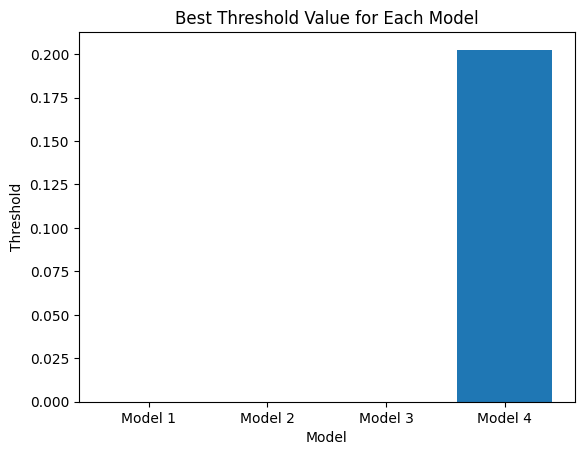

In [ ]:
# plot the threshold value for each model
plt.figure()
plt.bar(['Model 1', 'Model 2', 'Model 3', 'Model 4'], all_best_thresholds)
plt.xlabel('Model')
plt.ylabel('Threshold')
plt.title('Best Threshold Value for Each Model')
plt.show()


Testing Validation

Raw outputs


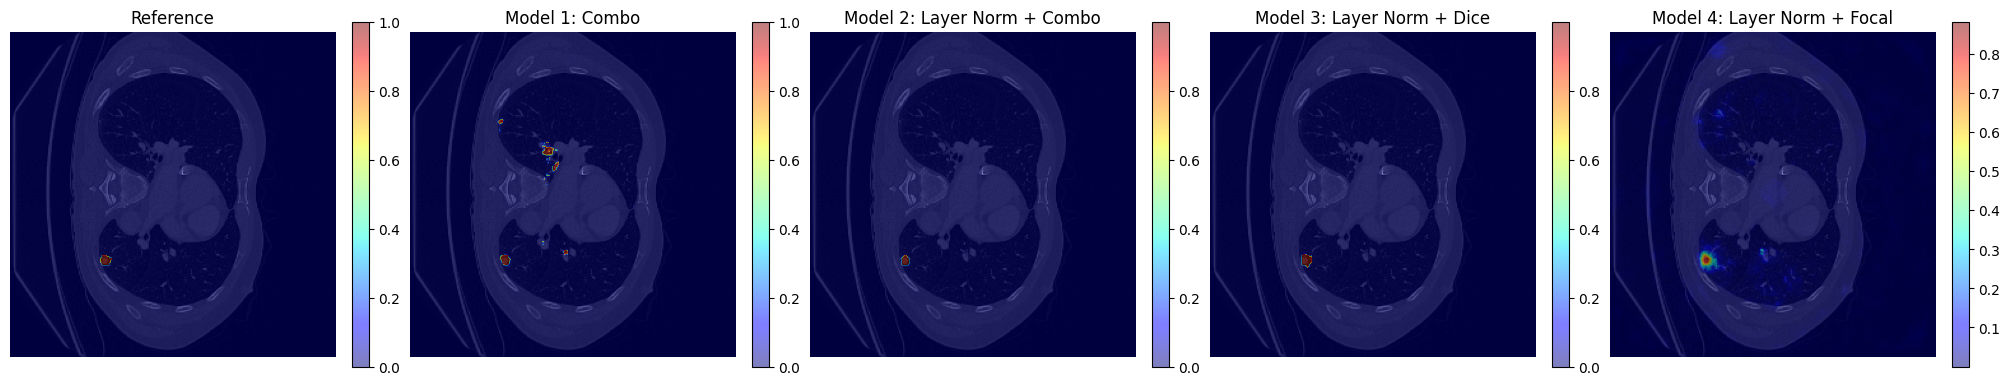

Threshold outputs


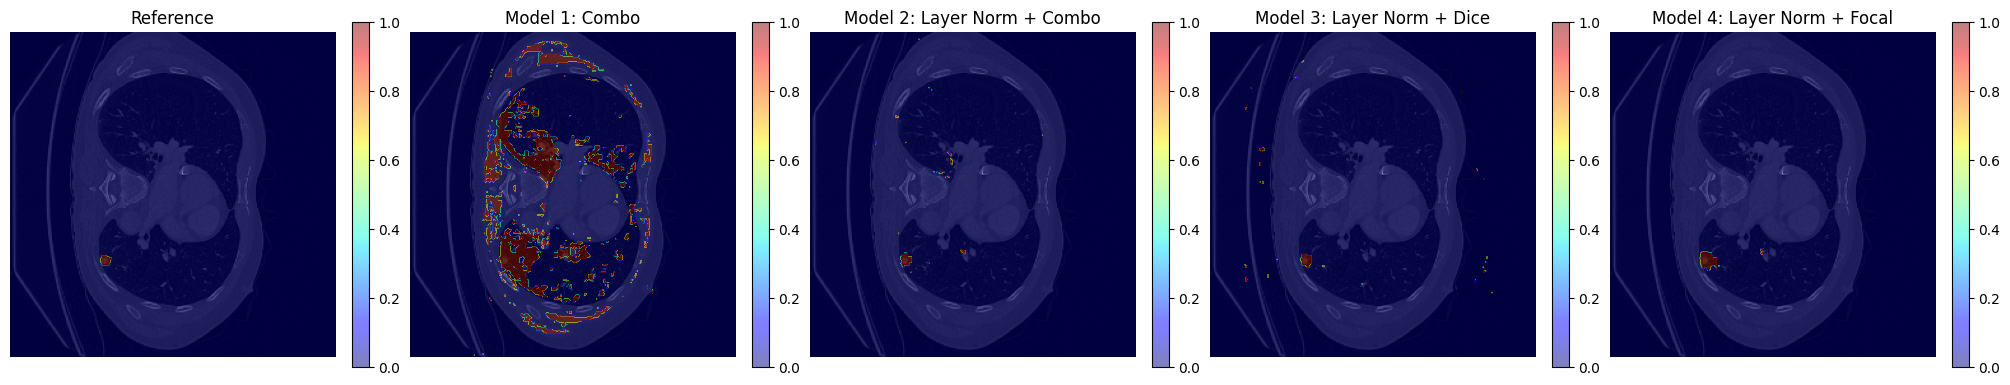

Dice 1: 0.023549201009251473
Dice 2: 0.6033519553072626
Dice 3: 0.5913978494623656
Dice 4: 0.5258215962441315

Model 1: TPR: 1.0, FPR: 0.07092241942882538
Model 2: TPR: 0.9642857313156128, FPR: 0.0010537569178268313
Model 3: TPR: 0.9821428656578064, FPR: 0.001145387883298099
Model 4: TPR: 1.0, FPR: 0.0015424557495862246


In [14]:
best_threshold_1 = 3.975856088800356e-05
best_threshold_2 = 1.526314008515328e-05
best_threshold_3 = 3.019135874637868e-08
best_threshold_4 = 0.20249894261360168
# evaluate all models
# use the best threshold to calculate the dice score
model_1.eval()
model_2.eval()
model_3.eval()
model_4.eval()

with torch.no_grad():
  scan, mask = next(iter(valloader))
  scan = scan.to(device)
  mask = mask.to(device)

  pred_1 = model_1(scan)
  pred_2 = model_2(scan)
  pred_3 = model_3(scan)
  pred_4 = model_4(scan)

  pred_1 = torch.sigmoid(pred_1)
  pred_2 = torch.sigmoid(pred_2)
  pred_3 = torch.sigmoid(pred_3)
  pred_4 = torch.sigmoid(pred_4)

  pred_1 = pred_1.cpu().numpy()
  pred_2 = pred_2.cpu().numpy()
  pred_3 = pred_3.cpu().numpy()
  pred_4 = pred_4.cpu().numpy()

  scan = scan.cpu().numpy()
  mask = mask.cpu().numpy()

  scan = scan.squeeze()
  mask = mask.squeeze()
  pred_1 = pred_1.squeeze()
  pred_2 = pred_2.squeeze()
  pred_3 = pred_3.squeeze()
  pred_4 = pred_4.squeeze()


  # Titles for the subplots
  titles = [
      "Reference",
      "Model 1: Combo",
      "Model 2: Layer Norm + Combo",
      "Model 3: Layer Norm + Dice",
      "Model 4: Layer Norm + Focal"
  ]


  # Data for the subplots
  overlays = [mask, pred_1, pred_2, pred_3, pred_4]


  print("Raw outputs")

  # create a new figure and subplots
  fig, axes = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)
  # Plot each subplot
  for ax, title, overlay in zip(axes, titles, overlays):
      im1 = ax.imshow(scan, cmap='gray')  # Base scan
      im2 = ax.imshow(overlay, alpha=0.5, cmap='jet')  # Overlayed mask/prediction
      cbar = fig.colorbar(im2, ax=ax, shrink=0.7)  # Shrink colorbar to match subplot height
      ax.set_title(title)
      ax.axis('off')

  plt.show()

  # calculate dice score
  # use the best threshold to calculate the dice score
  pred_1 = (pred_1 > best_threshold_1).astype(np.float32)
  pred_2 = (pred_2 > best_threshold_2).astype(np.float32)
  pred_3 = (pred_3 > best_threshold_3).astype(np.float32)
  pred_4 = (pred_4 > best_threshold_4).astype(np.float32)



  mask = mask.astype(np.float32)

  # Data for the subplots
  overlays = [mask, pred_1, pred_2, pred_3, pred_4]

  print("Threshold outputs")

  # create a new figure and subplots
  fig, axes = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)

  # Plot each subplot
  for ax, title, overlay in zip(axes, titles, overlays):
      im1 = ax.imshow(scan, cmap='gray')  # Base scan
      im2 = ax.imshow(overlay, alpha=0.5, cmap='jet')  # Overlayed mask/prediction
      cbar = fig.colorbar(im2, ax=ax, shrink=0.7)  # Shrink colorbar to match subplot height
      ax.set_title(title)
      ax.axis('off')

  plt.show()

  def dice_score(pred, mask):
    intersection = np.sum(pred * mask)
    return 2 * intersection / (np.sum(pred) + np.sum(mask))

  dice_1 = dice_score(pred_1, mask)
  dice_2 = dice_score(pred_2, mask)
  dice_3 = dice_score(pred_3, mask)
  dice_4 = dice_score(pred_4, mask)

  print("Dice 1: {}".format(dice_1))
  print("Dice 2: {}".format(dice_2))
  print("Dice 3: {}".format(dice_3))
  print("Dice 4: {}".format(dice_4))
  print()

  # calculate fpr, tpr
  tpr_1 = np.sum(pred_1 * mask) / np.sum(mask)
  fpr_1 = np.sum(pred_1 * (1 - mask)) / np.sum(1 - mask)
  tpr_2 = np.sum(pred_2 * mask) / np.sum(mask)
  fpr_2 = np.sum(pred_2 * (1 - mask)) / np.sum(1 - mask)
  tpr_3 = np.sum(pred_3 * mask) / np.sum(mask)
  fpr_3 = np.sum(pred_3 * (1 - mask)) / np.sum(1 - mask)
  tpr_4 = np.sum(pred_4 * mask) / np.sum(mask)
  fpr_4 = np.sum(pred_4 * (1 - mask)) / np.sum(1 - mask)

  print("Model 1: TPR: {}, FPR: {}".format(tpr_1, fpr_1))
  print("Model 2: TPR: {}, FPR: {}".format(tpr_2, fpr_2))
  print("Model 3: TPR: {}, FPR: {}".format(tpr_3, fpr_3))
  print("Model 4: TPR: {}, FPR: {}".format(tpr_4, fpr_4))







In [ ]:
# use dice score to find the best threshold for each model
def find_best_threshold_dice(model, dataloader):
  model.eval()
  model.to(device)
  # create threshold range from 0 to 1
  threshold_range = np.linspace(0, 1, 11)
  average_dice_scores = []
  outputs = []
  scans = []
  masks = []
  with torch.no_grad():
    for i, (scan, mask) in enumerate(dataloader):
      scan = scan.to(device)
      mask = mask.to(device)
      output = model(scan)
      output = torch.sigmoid(output)
      output = output.cpu().numpy().flatten()
      mask = mask.cpu().numpy().flatten()
      outputs.append(output)
      scans.append(scan)
      masks.append(mask)

    for threshold in threshold_range:
      dice_scores = []
      for i in range(len(outputs)):
        pred = (outputs[i] >= threshold).astype(np.float32)
        mask = masks[i]
        dice_scores.append(dice_score(pred, mask))
      average_dice_scores.append(np.mean(dice_scores))
      # print percentage of progress
      print(threshold)

    best_threshold_index = np.argmax(average_dice_scores)
    best_threshold = threshold_range[best_threshold_index]
    return best_threshold

best_threshold_dice_1 = find_best_threshold_dice(model_1, trainloader)
best_threshold_dice_2 = find_best_threshold_dice(model_2, trainloader)
best_threshold_dice_3 = find_best_threshold_dice(model_3, trainloader)
best_threshold_dice_4 = find_best_threshold_dice(model_4, trainloader)

print()
print("Best threshold using dice score for model 1: {}".format(best_threshold_dice_1))
print("Best threshold using dice score for model 2: {}".format(best_threshold_dice_2))
print("Best threshold using dice score for model 3: {}".format(best_threshold_dice_3))
print("Best threshold using dice score for model 4: {}".format(best_threshold_dice_4))



0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0

Best threshold using dice score for model 1: 0.30000000000000004
Best threshold using dice score for model 2: 0.5
Best threshold using dice score for model 3: 0.4
Best threshold using dice score for model 4: 0.5


Raw outputs


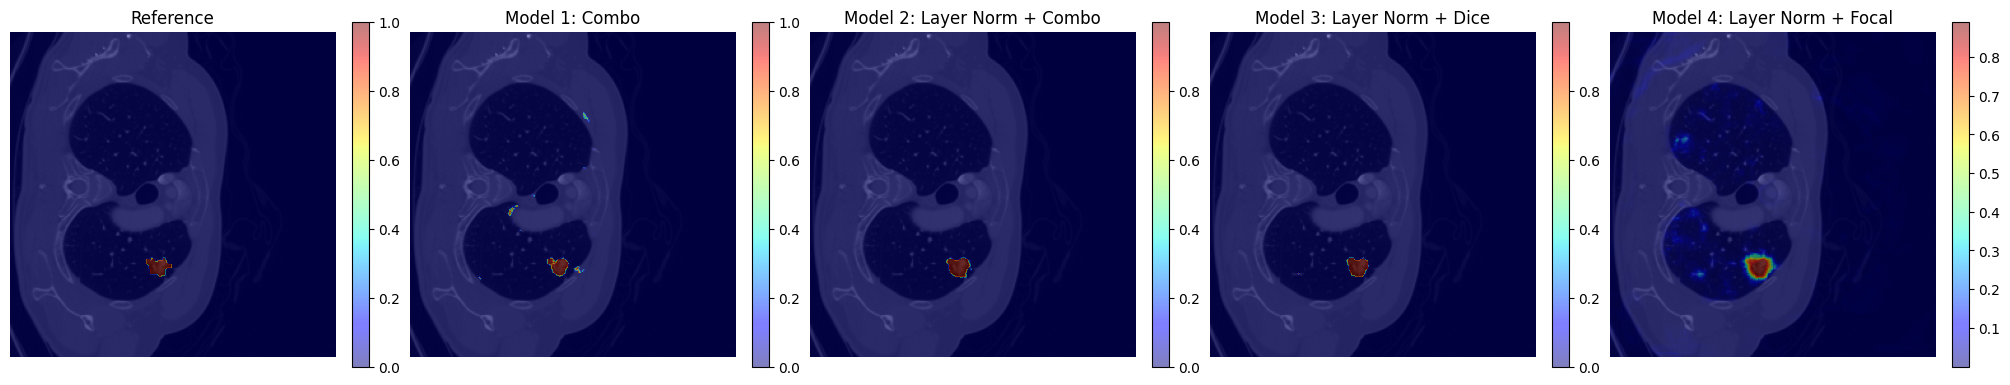


Threshold outputs using best threshold from ROC curve


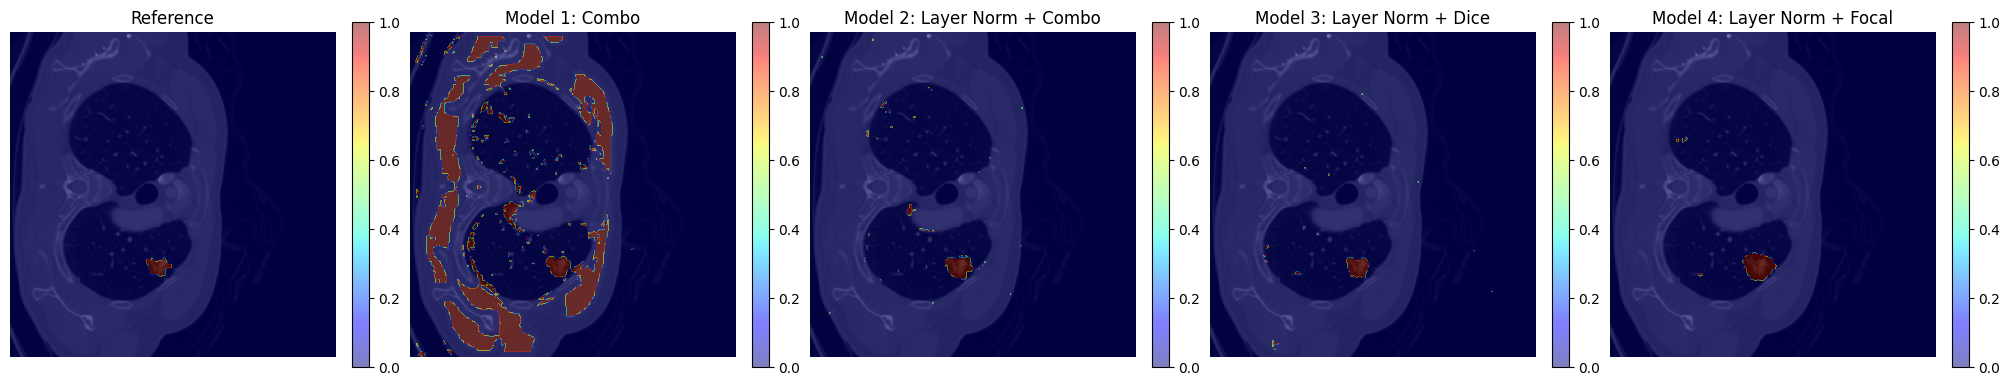

Dice 1: 0.046474782149458674
Dice 2: 0.6465364120781527
Dice 3: 0.7972665148063781
Dice 4: 0.6029654036243822

Model 1: TPR: 0.9617486596107483, FPR: 0.11040043830871582
Model 2: TPR: 0.994535505771637, FPR: 0.0030297001358121634
Model 3: TPR: 0.9562841653823853, FPR: 0.001239422825165093
Model 4: TPR: 1.0, FPR: 0.003687665332108736


Threshold outputs using best threshold from dice score


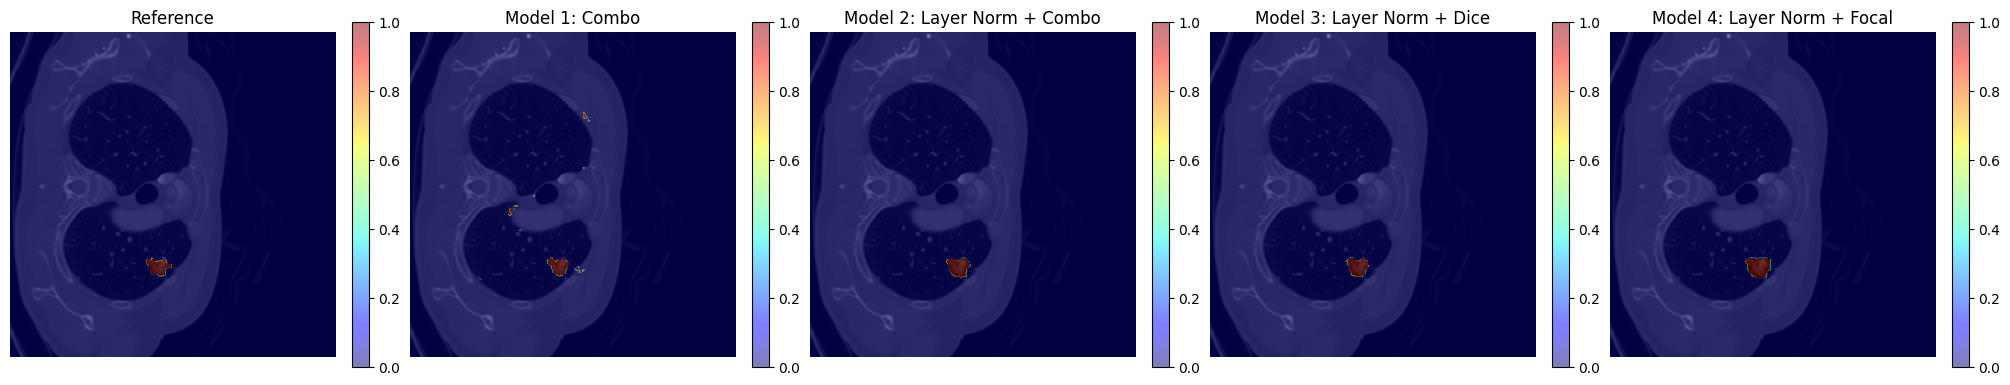

Dice 1: 0.7551020408163265
Dice 2: 0.8940568475452196
Dice 3: 0.9013333333333333
Dice 4: 0.8237986270022883

Model 1: TPR: 0.8087431788444519, FPR: 0.0009333924972452223
Model 2: TPR: 0.9453551769256592, FPR: 0.0004743470053654164
Model 3: TPR: 0.9234972596168518, FPR: 0.00035193486837670207
Model 4: TPR: 0.9836065769195557, FPR: 0.0011323122307658195


In [19]:
best_threshold_dice = [0.3, 0.5, 0.4, 0.5]
best_threshold_roc = [best_threshold_1, best_threshold_2, best_threshold_3, best_threshold_4]

# test the best threshold using dice score on test set
model_1.to(device)
model_2.to(device)
model_3.to(device)
model_4.to(device)

model_1.eval()
model_2.eval()
model_3.eval()
model_4.eval()

with torch.no_grad():
    scan, mask = next(iter(testloader))
    scan = scan.to(device)
    mask = mask.to(device)

    pred_1 = model_1(scan)
    pred_2 = model_2(scan)
    pred_3 = model_3(scan)
    pred_4 = model_4(scan)

    pred_1 = torch.sigmoid(pred_1)
    pred_2 = torch.sigmoid(pred_2)
    pred_3 = torch.sigmoid(pred_3)
    pred_4 = torch.sigmoid(pred_4)

    pred_1 = pred_1.cpu().numpy()
    pred_2 = pred_2.cpu().numpy()
    pred_3 = pred_3.cpu().numpy()
    pred_4 = pred_4.cpu().numpy()

    scan = scan.cpu().numpy()
    mask = mask.cpu().numpy()

    scan = scan.squeeze()
    mask = mask.squeeze()
    pred_1 = pred_1.squeeze()
    pred_2 = pred_2.squeeze()
    pred_3 = pred_3.squeeze()
    pred_4 = pred_4.squeeze()


    # Titles for the subplots
    titles = [
        "Reference",
        "Model 1: Combo",
        "Model 2: Layer Norm + Combo",
        "Model 3: Layer Norm + Dice",
        "Model 4: Layer Norm + Focal"
    ]

    mask = mask.astype(np.float32)

    # Data for the subplots
    overlays = [mask, pred_1, pred_2, pred_3, pred_4]

    print("Raw outputs")
    # create a new figure and subplots
    fig, axes = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)
    # Plot each subplot
    for ax, title, overlay in zip(axes, titles, overlays):
        im1 = ax.imshow(scan, cmap='gray')  # Base scan
        im2 = ax.imshow(overlay, alpha=0.5, cmap='jet')  # Overlayed mask/prediction
        cbar = fig.colorbar(im2, ax=ax, shrink=0.7)  # Shrink colorbar to match subplot height
        ax.set_title(title)
        ax.axis('off')

    plt.show()

    # use the best threshold from roc curve to calculate the dice score
    pred_1_roc = (pred_1 > best_threshold_roc[0]).astype(np.float32)
    pred_2_roc = (pred_2 > best_threshold_roc[1]).astype(np.float32)
    pred_3_roc = (pred_3 > best_threshold_roc[2]).astype(np.float32)
    pred_4_roc = (pred_4 > best_threshold_roc[3]).astype(np.float32)

    # Data for the subplots
    overlays = [mask, pred_1_roc, pred_2_roc, pred_3_roc, pred_4_roc]

    print()
    print("Threshold outputs using best threshold from ROC curve")

    # create a new figure and subplots
    fig, axes = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)

    # Plot each subplot
    for ax, title, overlay in zip(axes, titles, overlays):
        im1 = ax.imshow(scan, cmap='gray')  # Base scan
        im2 = ax.imshow(overlay, alpha=0.5, cmap='jet')  # Overlayed mask/prediction
        cbar = fig.colorbar(im2, ax=ax, shrink=0.7)  # Shrink colorbar to match subplot height
        ax.set_title(title)
        ax.axis('off')

    plt.show()

    # calculate dice score for roc curve threshold
    dice_1 = dice_score(pred_1_roc, mask)
    dice_2 = dice_score(pred_2_roc, mask)
    dice_3 = dice_score(pred_3_roc, mask)
    dice_4 = dice_score(pred_4_roc, mask)

    print("Dice 1: {}".format(dice_1))
    print("Dice 2: {}".format(dice_2))
    print("Dice 3: {}".format(dice_3))
    print("Dice 4: {}".format(dice_4))
    print()

    # calculate tpr, fpr
    tpr_1 = np.sum(pred_1_roc * mask) / np.sum(mask)
    fpr_1 = np.sum(pred_1_roc * (1 - mask)) / np.sum(1 - mask)
    tpr_2 = np.sum(pred_2_roc * mask) / np.sum(mask)
    fpr_2 = np.sum(pred_2_roc * (1 - mask)) / np.sum(1 - mask)
    tpr_3 = np.sum(pred_3_roc * mask) / np.sum(mask)
    fpr_3 = np.sum(pred_3_roc * (1 - mask)) / np.sum(1 - mask)
    tpr_4 = np.sum(pred_4_roc * mask) / np.sum(mask)
    fpr_4 = np.sum(pred_4_roc * (1 - mask)) / np.sum(1 - mask)

    print("Model 1: TPR: {}, FPR: {}".format(tpr_1, fpr_1))
    print("Model 2: TPR: {}, FPR: {}".format(tpr_2, fpr_2))
    print("Model 3: TPR: {}, FPR: {}".format(tpr_3, fpr_3))
    print("Model 4: TPR: {}, FPR: {}".format(tpr_4, fpr_4))
    print()

    # use the best threshold from dice score to calculate the dice score
    pred_1_dice = (pred_1 > best_threshold_dice[0]).astype(np.float32)
    pred_2_dice = (pred_2 > best_threshold_dice[1]).astype(np.float32)
    pred_3_dice = (pred_3 > best_threshold_dice[2]).astype(np.float32)
    pred_4_dice = (pred_4 > best_threshold_dice[3]).astype(np.float32)

    # Data for the subplots
    overlays = [mask, pred_1_dice, pred_2_dice, pred_3_dice, pred_4_dice]

    print()
    print("Threshold outputs using best threshold from dice score")

    # create a new figure and subplots
    fig, axes = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)

    # Plot each subplot
    for ax, title, overlay in zip(axes, titles, overlays):
        im1 = ax.imshow(scan, cmap='gray')  # Base scan
        im2 = ax.imshow(overlay, alpha=0.5, cmap='jet')  # Overlayed mask/prediction
        cbar = fig.colorbar(im2, ax=ax, shrink=0.7)  # Shrink colorbar to match subplot height
        ax.set_title(title)
        ax.axis('off')

    plt.show()

    # calculate dice score for dice score threshold
    dice_1 = dice_score(pred_1_dice, mask)
    dice_2 = dice_score(pred_2_dice, mask)
    dice_3 = dice_score(pred_3_dice, mask)
    dice_4 = dice_score(pred_4_dice, mask)

    print("Dice 1: {}".format(dice_1))
    print("Dice 2: {}".format(dice_2))
    print("Dice 3: {}".format(dice_3))
    print("Dice 4: {}".format(dice_4))
    print()

    # calculate tpr, fpr
    tpr_1 = np.sum(pred_1_dice * mask) / np.sum(mask)
    fpr_1 = np.sum(pred_1_dice * (1 - mask)) / np.sum(1 - mask)
    tpr_2 = np.sum(pred_2_dice * mask) / np.sum(mask)
    fpr_2 = np.sum(pred_2_dice * (1 - mask)) / np.sum(1 - mask)
    tpr_3 = np.sum(pred_3_dice * mask) / np.sum(mask)
    fpr_3 = np.sum(pred_3_dice * (1 - mask)) / np.sum(1 - mask)
    tpr_4 = np.sum(pred_4_dice * mask) / np.sum(mask)
    fpr_4 = np.sum(pred_4_dice * (1 - mask)) / np.sum(1 - mask)

    print("Model 1: TPR: {}, FPR: {}".format(tpr_1, fpr_1))
    print("Model 2: TPR: {}, FPR: {}".format(tpr_2, fpr_2))
    print("Model 3: TPR: {}, FPR: {}".format(tpr_3, fpr_3))
    print("Model 4: TPR: {}, FPR: {}".format(tpr_4, fpr_4))












In [ ]:
# find the average dice score for each model using the best threshold
# from roc curve and dice score
# use testloader
scans = []
masks = []
outputs_1 = []
outputs_2 = []
outputs_3 = []
outputs_4 = []

with torch.no_grad():
    for i, (scan, mask) in enumerate(testloader):
        scan = scan.to(device)
        mask = mask.to(device)
        pred_1 = model_1(scan)
        pred_2 = model_2(scan)
        pred_3 = model_3(scan)
        pred_4 = model_4(scan)
        pred_1 = torch.sigmoid(pred_1)
        pred_2 = torch.sigmoid(pred_2)
        pred_3 = torch.sigmoid(pred_3)
        pred_4 = torch.sigmoid(pred_4)
        pred_1 = pred_1.cpu().numpy().flatten()
        pred_2 = pred_2.cpu().numpy().flatten()
        pred_3 = pred_3.cpu().numpy().flatten()
        pred_4 = pred_4.cpu().numpy().flatten()
        mask = mask.cpu().numpy().flatten()
        scan = scan.cpu().numpy().flatten()
        scans.append(scan)
        masks.append(mask)
        outputs_1.append(pred_1)
        outputs_2.append(pred_2)
        outputs_3.append(pred_3)
        outputs_4.append(pred_4)

# calculate dice score for each model from roc curve threshold
average_dice_roc_1 = []
average_dice_roc_2 = []
average_dice_roc_3 = []
average_dice_roc_4 = []

for i in range(len(scans)):
    pred_1 = (outputs_1[i] > best_threshold_roc[0]).astype(np.float32)
    pred_2 = (outputs_2[i] > best_threshold_roc[1]).astype(np.float32)
    pred_3 = (outputs_3[i] > best_threshold_roc[2]).astype(np.float32)
    pred_4 = (outputs_4[i] > best_threshold_roc[3]).astype(np.float32)
    mask = masks[i]
    average_dice_roc_1.append(dice_score(pred_1, mask))
    average_dice_roc_2.append(dice_score(pred_2, mask))
    average_dice_roc_3.append(dice_score(pred_3, mask))
    average_dice_roc_4.append(dice_score(pred_4, mask))

average_dice_roc_1 = np.mean(average_dice_roc_1)
average_dice_roc_2 = np.mean(average_dice_roc_2)
average_dice_roc_3 = np.mean(average_dice_roc_3)
average_dice_roc_4 = np.mean(average_dice_roc_4)



# calculate dice score for each model from dice score threshold
average_dice_dice_1 = []
average_dice_dice_2 = []
average_dice_dice_3 = []
average_dice_dice_4 = []

for i in range(len(scans)):
    pred_1 = (outputs_1[i] > best_threshold_dice[0]).astype(np.float32)
    pred_2 = (outputs_2[i] > best_threshold_dice[1]).astype(np.float32)
    pred_3 = (outputs_3[i] > best_threshold_dice[2]).astype(np.float32)
    pred_4 = (outputs_4[i] > best_threshold_dice[3]).astype(np.float32)
    mask = masks[i]
    average_dice_dice_1.append(dice_score(pred_1, mask))
    average_dice_dice_2.append(dice_score(pred_2, mask))
    average_dice_dice_3.append(dice_score(pred_3, mask))
    average_dice_dice_4.append(dice_score(pred_4, mask))

average_dice_dice_1 = np.mean(average_dice_dice_1)
average_dice_dice_2 = np.mean(average_dice_dice_2)
average_dice_dice_3 = np.mean(average_dice_dice_3)
average_dice_dice_4 = np.mean(average_dice_dice_4)




# calculate tpr, fpr for each model using best threshold from roc curve
average_tpr_roc_1 = []
average_fpr_roc_1 = []
average_tpr_roc_2 = []
average_fpr_roc_2 = []
average_tpr_roc_3 = []
average_fpr_roc_3 = []
average_tpr_roc_4 = []
average_fpr_roc_4 = []

for i in range(len(scans)):
    pred_1 = (outputs_1[i] > best_threshold_roc[0]).astype(np.float32)
    pred_2 = (outputs_2[i] > best_threshold_roc[1]).astype(np.float32)
    pred_3 = (outputs_3[i] > best_threshold_roc[2]).astype(np.float32)
    pred_4 = (outputs_4[i] > best_threshold_roc[3]).astype(np.float32)
    mask = masks[i]
    tpr_1 = np.sum(pred_1 * mask) / np.sum(mask)
    fpr_1 = np.sum(pred_1 * (1 - mask)) / np.sum(1 - mask)
    tpr_2 = np.sum(pred_2 * mask) / np.sum(mask)
    fpr_2 = np.sum(pred_2 * (1 - mask)) / np.sum(1 - mask)
    tpr_3 = np.sum(pred_3 * mask) / np.sum(mask)
    fpr_3 = np.sum(pred_3 * (1 - mask)) / np.sum(1 - mask)
    tpr_4 = np.sum(pred_4 * mask) / np.sum(mask)
    fpr_4 = np.sum(pred_4 * (1 - mask)) / np.sum(1 - mask)
    average_tpr_roc_1.append(tpr_1)
    average_fpr_roc_1.append(fpr_1)
    average_tpr_roc_2.append(tpr_2)
    average_fpr_roc_2.append(fpr_2)
    average_tpr_roc_3.append(tpr_3)
    average_fpr_roc_3.append(fpr_3)
    average_tpr_roc_4.append(tpr_4)
    average_fpr_roc_4.append(fpr_4)

average_tpr_roc_1 = np.mean(average_tpr_roc_1)
average_fpr_roc_1 = np.mean(average_fpr_roc_1)
average_tpr_roc_2 = np.mean(average_tpr_roc_2)
average_fpr_roc_2 = np.mean(average_fpr_roc_2)
average_tpr_roc_3 = np.mean(average_tpr_roc_3)
average_fpr_roc_3 = np.mean(average_fpr_roc_3)
average_tpr_roc_4 = np.mean(average_tpr_roc_4)
average_fpr_roc_4 = np.mean(average_fpr_roc_4)

# calculate tpr, fpr for each model using best threshold from dice score
average_tpr_dice_1 = []
average_fpr_dice_1 = []
average_tpr_dice_2 = []
average_fpr_dice_2 = []
average_tpr_dice_3 = []
average_fpr_dice_3 = []
average_tpr_dice_4 = []
average_fpr_dice_4 = []

for i in range(len(scans)):
    pred_1 = (outputs_1[i] > best_threshold_dice[0]).astype(np.float32)
    pred_2 = (outputs_2[i] > best_threshold_dice[1]).astype(np.float32)
    pred_3 = (outputs_3[i] > best_threshold_dice[2]).astype(np.float32)
    pred_4 = (outputs_4[i] > best_threshold_dice[3]).astype(np.float32)
    mask = masks[i]
    tpr_1 = np.sum(pred_1 * mask) / np.sum(mask)
    fpr_1 = np.sum(pred_1 * (1 - mask)) / np.sum(1 - mask)
    tpr_2 = np.sum(pred_2 * mask) / np.sum(mask)
    fpr_2 = np.sum(pred_2 * (1 - mask)) / np.sum(1 - mask)
    tpr_3 = np.sum(pred_3 * mask) / np.sum(mask)
    fpr_3 = np.sum(pred_3 * (1 - mask)) / np.sum(1 - mask)
    tpr_4 = np.sum(pred_4 * mask) / np.sum(mask)
    fpr_4 = np.sum(pred_4 * (1 - mask)) / np.sum(1 - mask)
    average_tpr_dice_1.append(tpr_1)
    average_fpr_dice_1.append(fpr_1)
    average_tpr_dice_2.append(tpr_2)
    average_fpr_dice_2.append(fpr_2)
    average_tpr_dice_3.append(tpr_3)
    average_fpr_dice_3.append(fpr_3)
    average_tpr_dice_4.append(tpr_4)
    average_fpr_dice_4.append(fpr_4)

average_tpr_dice_1 = np.mean(average_tpr_dice_1)
average_fpr_dice_1 = np.mean(average_fpr_dice_1)
average_tpr_dice_2 = np.mean(average_tpr_dice_2)
average_fpr_dice_2 = np.mean(average_fpr_dice_2)
average_tpr_dice_3 = np.mean(average_tpr_dice_3)
average_fpr_dice_3 = np.mean(average_fpr_dice_3)
average_tpr_dice_4 = np.mean(average_tpr_dice_4)
average_fpr_dice_4 = np.mean(average_fpr_dice_4)

# round everything to 3 decimal places
average_dice_roc_1 = round(average_dice_roc_1, 3)
average_dice_roc_2 = round(average_dice_roc_2, 3)
average_dice_roc_3 = round(average_dice_roc_3, 3)
average_dice_roc_4 = round(average_dice_roc_4, 3)

average_dice_dice_1 = round(average_dice_dice_1, 3)
average_dice_dice_2 = round(average_dice_dice_2, 3)
average_dice_dice_3 = round(average_dice_dice_3, 3)
average_dice_dice_4 = round(average_dice_dice_4, 3)

average_tpr_roc_1 = round(average_tpr_roc_1, 3)
average_fpr_roc_1 = round(average_fpr_roc_1, 3)
average_tpr_roc_2 = round(average_tpr_roc_2, 3)
average_fpr_roc_2 = round(average_fpr_roc_2, 3)
average_tpr_roc_3 = round(average_tpr_roc_3, 3)
average_fpr_roc_3 = round(average_fpr_roc_3, 3)
average_tpr_roc_4 = round(average_tpr_roc_4, 3)
average_fpr_roc_4 = round(average_fpr_roc_4, 3)

average_tpr_dice_1 = round(average_tpr_dice_1, 3)
average_fpr_dice_1 = round(average_fpr_dice_1, 3)
average_tpr_dice_2 = round(average_tpr_dice_2, 3)
average_fpr_dice_2 = round(average_fpr_dice_2, 3)
average_tpr_dice_3 = round(average_tpr_dice_3, 3)
average_fpr_dice_3 = round(average_fpr_dice_3, 3)
average_tpr_dice_4 = round(average_tpr_dice_4, 3)
average_fpr_dice_4 = round(average_fpr_dice_4, 3)



# format the output, Model#, Threshold, Dice, TPR, FPR, round to 3 decimal places, separate by tab, force to 3 decimal places
print("Model Name\tMethod\tThreshold\tDice Score\tTPR\tFPR")
print()
print(f"Model 1\tROC\t{(best_threshold_roc[0]):.3f}\t{average_dice_roc_1:.3f}\t{average_tpr_roc_1:.3f}\t{average_fpr_roc_1:.3f}")
print(f"Model 1\tDice\t{(best_threshold_dice[0]):.3f}\t{average_dice_dice_1:.3f}\t{average_tpr_dice_1:.3f}\t{average_fpr_dice_1:.3f}")
print()
print(f"Model 2\tROC\t{(best_threshold_roc[1]):.3f}\t{average_dice_roc_2:.3f}\t{average_tpr_roc_2:.3f}\t{average_fpr_roc_2:.3f}")
print(f"Model 2\tDice\t{(best_threshold_dice[1]):.3f}\t{average_dice_dice_2:.3f}\t{average_tpr_dice_2:.3f}\t{average_fpr_dice_2:.3f}")
print()
print(f"Model 3\tROC\t{(best_threshold_roc[2]):.3f}\t{average_dice_roc_3:.3f}\t{average_tpr_roc_3:.3f}\t{average_fpr_roc_3:.3f}")
print(f"Model 3\tDice\t{(best_threshold_dice[2]):.3f}\t{average_dice_dice_3:.3f}\t{average_tpr_dice_3:.3f}\t{average_fpr_dice_3:.3f}")
print()
print(f"Model 4\tROC\t{(best_threshold_roc[3]):.3f}\t{average_dice_roc_4:.3f}\t{average_tpr_roc_4:.3f}\t{average_fpr_roc_4:.3f}")
print(f"Model 4\tDice\t{(best_threshold_dice[3]):.3f}\t{average_dice_dice_4:.3f}\t{average_tpr_dice_4:.3f}\t{average_fpr_dice_4:.3f}")









Model Name	Method	Threshold	Dice Score	TPR	FPR

Model 1	ROC	0.000	0.074	0.875	0.105
Model 1	Dice	0.300	0.390	0.487	0.003

Model 2	ROC	0.000	0.478	0.850	0.011
Model 2	Dice	0.500	0.731	0.727	0.001

Model 3	ROC	0.000	0.492	0.778	0.005
Model 3	Dice	0.400	0.708	0.714	0.001

Model 4	ROC	0.202	0.588	0.922	0.004
Model 4	Dice	0.500	0.754	0.809	0.001


In [ ]:
# find the average dice score for each model using the best threshold
# from roc curve and dice score
# use testloader
scans = []
masks = []
outputs_1 = []
outputs_2 = []
outputs_3 = []
outputs_4 = []

with torch.no_grad():
    for i, (scan, mask) in enumerate(trainloader):
        scan = scan.to(device)
        mask = mask.to(device)
        pred_1 = model_1(scan)
        pred_2 = model_2(scan)
        pred_3 = model_3(scan)
        pred_4 = model_4(scan)
        pred_1 = torch.sigmoid(pred_1)
        pred_2 = torch.sigmoid(pred_2)
        pred_3 = torch.sigmoid(pred_3)
        pred_4 = torch.sigmoid(pred_4)
        pred_1 = pred_1.cpu().numpy().flatten()
        pred_2 = pred_2.cpu().numpy().flatten()
        pred_3 = pred_3.cpu().numpy().flatten()
        pred_4 = pred_4.cpu().numpy().flatten()
        mask = mask.cpu().numpy().flatten()
        scan = scan.cpu().numpy().flatten()
        scans.append(scan)
        masks.append(mask)
        outputs_1.append(pred_1)
        outputs_2.append(pred_2)
        outputs_3.append(pred_3)
        outputs_4.append(pred_4)

# calculate dice score for each model from roc curve threshold
average_dice_roc_1 = []
average_dice_roc_2 = []
average_dice_roc_3 = []
average_dice_roc_4 = []

for i in range(len(scans)):
    pred_1 = (outputs_1[i] > best_threshold_roc[0]).astype(np.float32)
    pred_2 = (outputs_2[i] > best_threshold_roc[1]).astype(np.float32)
    pred_3 = (outputs_3[i] > best_threshold_roc[2]).astype(np.float32)
    pred_4 = (outputs_4[i] > best_threshold_roc[3]).astype(np.float32)
    mask = masks[i]
    average_dice_roc_1.append(dice_score(pred_1, mask))
    average_dice_roc_2.append(dice_score(pred_2, mask))
    average_dice_roc_3.append(dice_score(pred_3, mask))
    average_dice_roc_4.append(dice_score(pred_4, mask))

average_dice_roc_1 = np.mean(average_dice_roc_1)
average_dice_roc_2 = np.mean(average_dice_roc_2)
average_dice_roc_3 = np.mean(average_dice_roc_3)
average_dice_roc_4 = np.mean(average_dice_roc_4)



# calculate dice score for each model from dice score threshold
average_dice_dice_1 = []
average_dice_dice_2 = []
average_dice_dice_3 = []
average_dice_dice_4 = []

for i in range(len(scans)):
    pred_1 = (outputs_1[i] > best_threshold_dice[0]).astype(np.float32)
    pred_2 = (outputs_2[i] > best_threshold_dice[1]).astype(np.float32)
    pred_3 = (outputs_3[i] > best_threshold_dice[2]).astype(np.float32)
    pred_4 = (outputs_4[i] > best_threshold_dice[3]).astype(np.float32)
    mask = masks[i]
    average_dice_dice_1.append(dice_score(pred_1, mask))
    average_dice_dice_2.append(dice_score(pred_2, mask))
    average_dice_dice_3.append(dice_score(pred_3, mask))
    average_dice_dice_4.append(dice_score(pred_4, mask))

average_dice_dice_1 = np.mean(average_dice_dice_1)
average_dice_dice_2 = np.mean(average_dice_dice_2)
average_dice_dice_3 = np.mean(average_dice_dice_3)
average_dice_dice_4 = np.mean(average_dice_dice_4)




# calculate tpr, fpr for each model using best threshold from roc curve
average_tpr_roc_1 = []
average_fpr_roc_1 = []
average_tpr_roc_2 = []
average_fpr_roc_2 = []
average_tpr_roc_3 = []
average_fpr_roc_3 = []
average_tpr_roc_4 = []
average_fpr_roc_4 = []

for i in range(len(scans)):
    pred_1 = (outputs_1[i] > best_threshold_roc[0]).astype(np.float32)
    pred_2 = (outputs_2[i] > best_threshold_roc[1]).astype(np.float32)
    pred_3 = (outputs_3[i] > best_threshold_roc[2]).astype(np.float32)
    pred_4 = (outputs_4[i] > best_threshold_roc[3]).astype(np.float32)
    mask = masks[i]
    tpr_1 = np.sum(pred_1 * mask) / np.sum(mask)
    fpr_1 = np.sum(pred_1 * (1 - mask)) / np.sum(1 - mask)
    tpr_2 = np.sum(pred_2 * mask) / np.sum(mask)
    fpr_2 = np.sum(pred_2 * (1 - mask)) / np.sum(1 - mask)
    tpr_3 = np.sum(pred_3 * mask) / np.sum(mask)
    fpr_3 = np.sum(pred_3 * (1 - mask)) / np.sum(1 - mask)
    tpr_4 = np.sum(pred_4 * mask) / np.sum(mask)
    fpr_4 = np.sum(pred_4 * (1 - mask)) / np.sum(1 - mask)
    average_tpr_roc_1.append(tpr_1)
    average_fpr_roc_1.append(fpr_1)
    average_tpr_roc_2.append(tpr_2)
    average_fpr_roc_2.append(fpr_2)
    average_tpr_roc_3.append(tpr_3)
    average_fpr_roc_3.append(fpr_3)
    average_tpr_roc_4.append(tpr_4)
    average_fpr_roc_4.append(fpr_4)

average_tpr_roc_1 = np.mean(average_tpr_roc_1)
average_fpr_roc_1 = np.mean(average_fpr_roc_1)
average_tpr_roc_2 = np.mean(average_tpr_roc_2)
average_fpr_roc_2 = np.mean(average_fpr_roc_2)
average_tpr_roc_3 = np.mean(average_tpr_roc_3)
average_fpr_roc_3 = np.mean(average_fpr_roc_3)
average_tpr_roc_4 = np.mean(average_tpr_roc_4)
average_fpr_roc_4 = np.mean(average_fpr_roc_4)

# calculate tpr, fpr for each model using best threshold from dice score
average_tpr_dice_1 = []
average_fpr_dice_1 = []
average_tpr_dice_2 = []
average_fpr_dice_2 = []
average_tpr_dice_3 = []
average_fpr_dice_3 = []
average_tpr_dice_4 = []
average_fpr_dice_4 = []

for i in range(len(scans)):
    pred_1 = (outputs_1[i] > best_threshold_dice[0]).astype(np.float32)
    pred_2 = (outputs_2[i] > best_threshold_dice[1]).astype(np.float32)
    pred_3 = (outputs_3[i] > best_threshold_dice[2]).astype(np.float32)
    pred_4 = (outputs_4[i] > best_threshold_dice[3]).astype(np.float32)
    mask = masks[i]
    tpr_1 = np.sum(pred_1 * mask) / np.sum(mask)
    fpr_1 = np.sum(pred_1 * (1 - mask)) / np.sum(1 - mask)
    tpr_2 = np.sum(pred_2 * mask) / np.sum(mask)
    fpr_2 = np.sum(pred_2 * (1 - mask)) / np.sum(1 - mask)
    tpr_3 = np.sum(pred_3 * mask) / np.sum(mask)
    fpr_3 = np.sum(pred_3 * (1 - mask)) / np.sum(1 - mask)
    tpr_4 = np.sum(pred_4 * mask) / np.sum(mask)
    fpr_4 = np.sum(pred_4 * (1 - mask)) / np.sum(1 - mask)
    average_tpr_dice_1.append(tpr_1)
    average_fpr_dice_1.append(fpr_1)
    average_tpr_dice_2.append(tpr_2)
    average_fpr_dice_2.append(fpr_2)
    average_tpr_dice_3.append(tpr_3)
    average_fpr_dice_3.append(fpr_3)
    average_tpr_dice_4.append(tpr_4)
    average_fpr_dice_4.append(fpr_4)

average_tpr_dice_1 = np.mean(average_tpr_dice_1)
average_fpr_dice_1 = np.mean(average_fpr_dice_1)
average_tpr_dice_2 = np.mean(average_tpr_dice_2)
average_fpr_dice_2 = np.mean(average_fpr_dice_2)
average_tpr_dice_3 = np.mean(average_tpr_dice_3)
average_fpr_dice_3 = np.mean(average_fpr_dice_3)
average_tpr_dice_4 = np.mean(average_tpr_dice_4)
average_fpr_dice_4 = np.mean(average_fpr_dice_4)

# round everything to 3 decimal places
average_dice_roc_1 = round(average_dice_roc_1, 3)
average_dice_roc_2 = round(average_dice_roc_2, 3)
average_dice_roc_3 = round(average_dice_roc_3, 3)
average_dice_roc_4 = round(average_dice_roc_4, 3)

average_dice_dice_1 = round(average_dice_dice_1, 3)
average_dice_dice_2 = round(average_dice_dice_2, 3)
average_dice_dice_3 = round(average_dice_dice_3, 3)
average_dice_dice_4 = round(average_dice_dice_4, 3)

average_tpr_roc_1 = round(average_tpr_roc_1, 3)
average_fpr_roc_1 = round(average_fpr_roc_1, 3)
average_tpr_roc_2 = round(average_tpr_roc_2, 3)
average_fpr_roc_2 = round(average_fpr_roc_2, 3)
average_tpr_roc_3 = round(average_tpr_roc_3, 3)
average_fpr_roc_3 = round(average_fpr_roc_3, 3)
average_tpr_roc_4 = round(average_tpr_roc_4, 3)
average_fpr_roc_4 = round(average_fpr_roc_4, 3)

average_tpr_dice_1 = round(average_tpr_dice_1, 3)
average_fpr_dice_1 = round(average_fpr_dice_1, 3)
average_tpr_dice_2 = round(average_tpr_dice_2, 3)
average_fpr_dice_2 = round(average_fpr_dice_2, 3)
average_tpr_dice_3 = round(average_tpr_dice_3, 3)
average_fpr_dice_3 = round(average_fpr_dice_3, 3)
average_tpr_dice_4 = round(average_tpr_dice_4, 3)
average_fpr_dice_4 = round(average_fpr_dice_4, 3)



# format the output, Model#, Threshold, Dice, TPR, FPR, round to 3 decimal places, separate by tab, force to 3 decimal places
print()
print("Model# Method Thresho Dice TPR FPR")
print()
print(f"Model 1\tROC\t{(best_threshold_roc[0]):.3f}\t{average_dice_roc_1:.3f}\t{average_tpr_roc_1:.3f}\t{average_fpr_roc_1:.3f}")
print(f"Model 1\tDice\t{(best_threshold_dice[0]):.3f}\t{average_dice_dice_1:.3f}\t{average_tpr_dice_1:.3f}\t{average_fpr_dice_1:.3f}")
print()
print(f"Model 2\tROC\t{(best_threshold_roc[1]):.3f}\t{average_dice_roc_2:.3f}\t{average_tpr_roc_2:.3f}\t{average_fpr_roc_2:.3f}")
print(f"Model 2\tDice\t{(best_threshold_dice[1]):.3f}\t{average_dice_dice_2:.3f}\t{average_tpr_dice_2:.3f}\t{average_fpr_dice_2:.3f}")
print()
print(f"Model 3\tROC\t{(best_threshold_roc[2]):.3f}\t{average_dice_roc_3:.3f}\t{average_tpr_roc_3:.3f}\t{average_fpr_roc_3:.3f}")
print(f"Model 3\tDice\t{(best_threshold_dice[2]):.3f}\t{average_dice_dice_3:.3f}\t{average_tpr_dice_3:.3f}\t{average_fpr_dice_3:.3f}")
print()
print(f"Model 4\tROC\t{(best_threshold_roc[3]):.3f}\t{average_dice_roc_4:.3f}\t{average_tpr_roc_4:.3f}\t{average_fpr_roc_4:.3f}")
print(f"Model 4\tDice\t{(best_threshold_dice[3]):.3f}\t{average_dice_dice_4:.3f}\t{average_tpr_dice_4:.3f}\t{average_fpr_dice_4:.3f}")





Model# Method Thresho Dice TPR FPR

Model 1	ROC	0.000	0.080	0.854	0.104
Model 1	Dice	0.300	0.378	0.453	0.004

Model 2	ROC	0.000	0.496	0.887	0.012
Model 2	Dice	0.500	0.786	0.800	0.001

Model 3	ROC	0.000	0.529	0.821	0.005
Model 3	Dice	0.400	0.769	0.777	0.001

Model 4	ROC	0.202	0.619	0.980	0.004
Model 4	Dice	0.500	0.804	0.877	0.001
